# Introduction

The purpose of this project is to examine crime data in Los Angeles. The data comes from the lacity's website. The dataset reflects incidents of crime in the City of Los Angeles dating back to 2010. The dataset is available via API.

Questions I will be examining
1. Are certain areas more prone to crimes?
2. Are there certain times where more crimes are occuring?
3. Are there subpopulations which are more often targets of crime?
4. What weapons are most often used?

In [1]:
#Import relevant packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sodapy import Socrata
import statsmodels.api as sm
import uszipcode
import datetime
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from uszipcode import ZipcodeSearchEngine
from geopy.geocoders import Nominatim
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as sm
from sklearn import metrics

C:\Users\Jai Dave\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Loading and Cleaning the Data

In [2]:
#Load environment variables
un = os.environ.get("usn")
pwd = os.environ.get("pswd")
print(un)

jbdave112@gmail.com


In [ ]:
#Load data from La city's database
client = Socrata('data.lacity.org', 'jc1TayctCju6pIwQcAsHYImnr', username=un, password=pwd)
results = client.get("7fvc-faax", limit = 1800000)
crime_df = pd.DataFrame.from_records(results)

In [4]:
#Examine the structure of the data
crime_df.head()

,area_id,area_name,crm_cd,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,crm_cd_desc,cross_street,date_occ,...,premis_desc,rpt_dist_no,status,status_desc,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd
0,01,Central,821,821,NaN,NaN,NaN,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,SAN PEDRO,2010-11-15T00:00:00.000,...,SIDEWALK,0157,AO,Adult Other,2045,30,H,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400
1,02,Rampart,810,810,NaN,NaN,NaN,"SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W...",NaN,2010-03-01T00:00:00.000,...,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0248,AA,Adult Arrest,0001,11,H,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400
2,07,Wilshire,626,626,NaN,NaN,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,NaN,2010-11-15T00:00:00.000,...,SINGLE FAMILY DWELLING,0782,AA,Adult Arrest,0030,49,H,F,NaN,NaN
3,07,Wilshire,930,930,NaN,NaN,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,NaN,2010-03-12T00:00:00.000,...,PARK/PLAYGROUND,0724,AA,Adult Arrest,1050,41,B,M,VERBAL THREAT,511
4,07,Wilshire,626,626,NaN,NaN,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,NaN,2010-03-13T00:00:00.000,...,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0735,AA,Adult Arrest,0600,27,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400


In [5]:
#Drop columns with more than 70% of the data missing and coding columns, crm_cd_1 is the same as crm_cd so I will drop that as well
crime_df= crime_df[[column for column in crime_df if crime_df[column].count() / len(crime_df) >= 0.3]]
crime_df = crime_df.drop(['crm_cd_1'], 1)

In [5]:
#Fill Premis Descriptions for which their is already a description assigned to a code, this will only work for rows with a premis code
premise_codes = crime_df.premis_cd.unique()
premise = crime_df.premis_desc.unique()
premise_dict = dict(zip(premise_codes, premise))
crime_df.premis_desc = crime_df.premis_desc.fillna(crime_df.premis_cd.map(premise_dict))
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764551 entries, 0 to 1764550
Data columns (total 21 columns):
area_id           object
area_name         object
crm_cd            object
crm_cd_desc       object
date_occ          object
date_rptd         object
dr_no             object
location          object
location_1        object
mocodes           object
premis_cd         object
premis_desc       object
rpt_dist_no       object
status            object
status_desc       object
time_occ          object
vict_age          object
vict_descent      object
vict_sex          object
weapon_desc       object
weapon_used_cd    object
dtypes: object(21)
memory usage: 282.7+ MB


In [6]:
#Remove rows with an na value as the location
crime_df = crime_df[pd.notnull(crime_df['location_1'])]

In [7]:
#Create columns containing longitude and latitude data
def get_long(coordinates):
    return coordinates['coordinates'][0]
def get_lat(coordinates):
    return coordinates['coordinates'][1]
crime_df['longitude'] = crime_df['location_1'].apply(get_long)
crime_df['latitude'] =crime_df['location_1'].apply(get_lat)

In [8]:
#Drop rows with (0,0) location data
crime_df = crime_df[crime_df.longitude != 0]

In [9]:
#Create a column that contains the zipcode where the crime occurred
search = ZipcodeSearchEngine()
def get_zip(latitude, longitude):
    res = search.by_coordinate(latitude, longitude, radius=30, returns=1)
    return res[0]['Zipcode']
crime_df['zipcode'] = crime_df.apply(lambda x: get_zip(x['latitude'], x['longitude']), axis=1)

## Crime Over Time

In [10]:
#Change time format
crime_df['time'] = crime_df['time_occ'].str[0:2] + ':' + crime_df['time_occ'].str[2:4]

In [11]:
#Combine time and date columns
crime_df['dt'] = crime_df['date_occ'].str[0:10] + ' ' + crime_df['time']

Text(0.5,0,'Year')

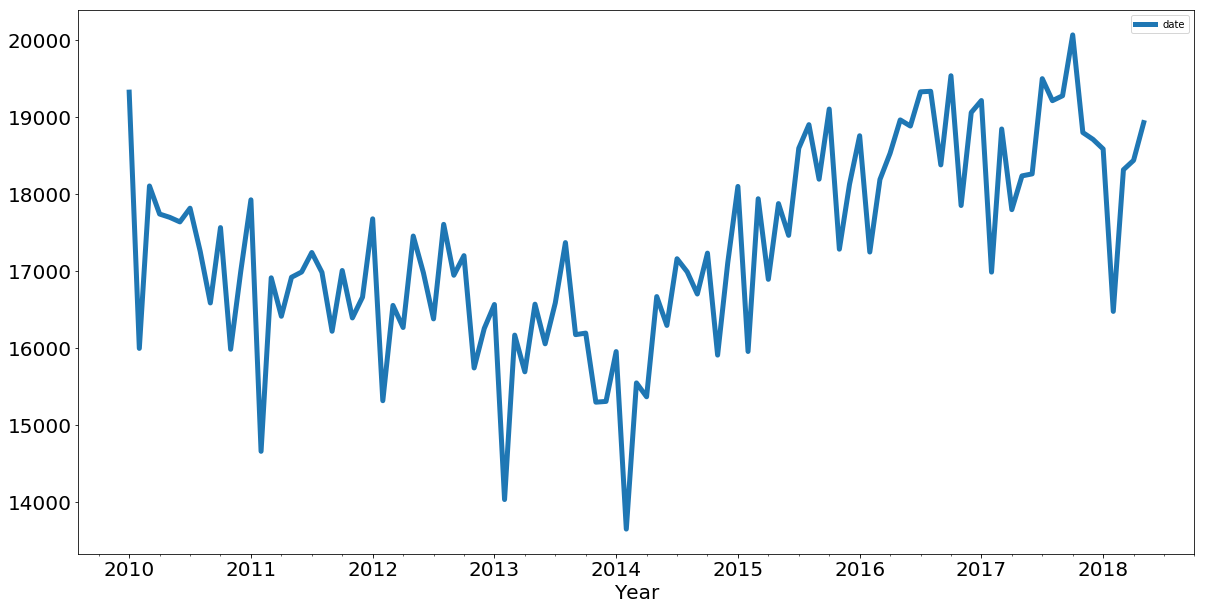

In [12]:
#Create datetime
time_format = '%Y-%m-%d %H:%M'
crime_df['date'] = pd.to_datetime(crime_df['dt'], format = time_format)

#Create a dataframe with the date column created above
time_df = crime_df.loc[:, ['date']]

#Exclude latest month as the month is not over yet
time_df = time_df.loc[~(time_df['date'].dt.month.eq(6) & time_df['date'].dt.year.eq(2018))]

#Reindex with the date and plot data by month
time_df.index = time_df['date']
time_df.resample('M').count().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

In [13]:
#Group time by hour
crime_df['hour'] = [r.hour for r in crime_df.date]

## Crimes and Weapons Used

In [45]:
#The ten most frequent crimes in LA since 2010
crime_df.groupby('crm_cd_desc').crm_cd.count().sort_values(ascending=False).head(10)

crm_cd_desc
BATTERY - SIMPLE ASSAULT                                        159584
VEHICLE - STOLEN                                                134415
BURGLARY FROM VEHICLE                                           134399
BURGLARY                                                        125482
THEFT PLAIN - PETTY ($950 & UNDER)                              124152
THEFT OF IDENTITY                                               109289
INTIMATE PARTNER - SIMPLE ASSAULT                                94563
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114     88039
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                         77644
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT                   74971
Name: crm_cd, dtype: int64

To identify what weapons are frequently used, I will isolate the crime_cd_desc "Assault with deadly weapon, aggravated assault" and get counts for the different weapons used. Crime code 230 corresponds to Assault with a deadly weapon, aggravated assault.

In [168]:
#Weapons used frequently for Assaults
weapons = crime_df[crime_df['crm_cd']=='230']

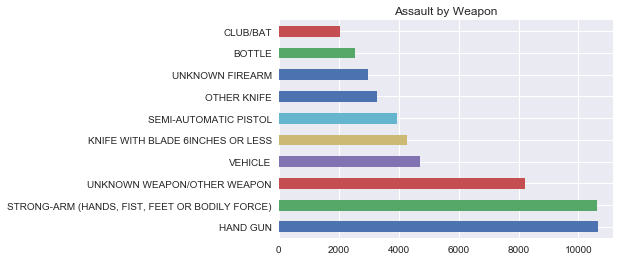

In [169]:
#Plot most frequently used weapons for assaults
ax = weapons['weapon_desc'].value_counts()[:10].plot(kind='barh', title = 'Assault by Weapon')

From the plot above one can see that hand guns are the most used weapon in crimes coded as "Assault with deadly weapon, aggravated assault". Los Angeles has an anonomyous gun buy back program. Perhaps by creating similar programs or increasing awareness of the program would reduce the number of assaults with the use of a gun.

## Crimes by Location

{'01': 'Central', '02': 'Rampart', '07': 'Wilshire', '08': 'West LA', '20': 'Olympic', '03': 'Southwest', '09': 'Van Nuys', '16': 'Foothill', '18': 'Southeast', '21': 'Topanga', '10': 'West Valley', '12': '77th Street', '13': 'Newton', '15': 'N Hollywood', '04': 'Hollenbeck', '05': 'Harbor', '06': 'Hollywood', '17': 'Devonshire', '11': 'Northeast', '14': 'Pacific', '19': 'Mission'}


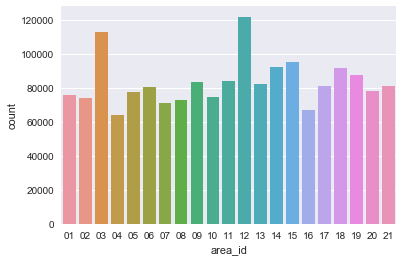

In [17]:
#Get Distinct area ids and area names
area_ids = crime_df.area_id.unique()
area_names = crime_df.area_name.unique()

#Create dictionay with area id as the key and area name as the value
area_dict = dict(zip(area_ids, area_names))
print(area_dict)

#Plot the count of crimes in each area
sns.set(style="darkgrid")
ax = sns.countplot(x='area_id', data = crime_df)

Areas with significantly more crimes are "77th street" and the "Southwest region". From this graph we can not tell if this is a result of those areas containing a larger share of LA's population. To test this I will use a proportion test using data taken from the LAPD's website. According to the website the 77th street area has a population of approximately 175,000. According to the United States Census Bureau Los Angles has a population of approxiately 3,976,000. To test if the 77th street area is more prone to crime I will do a proportion z test. http://www.lapdonline.org/77th_street_community_police_station/content_basic_view/1573

In [171]:
#Calculate the total amount of crimes in the dataset and the total count of crimes in 77th street area
total_count = crime_df.crm_cd.count()
Area_77 = crime_df[crime_df['area_id']=='12']['crm_cd']
count_77 = Area_77.count()

"""Use a proportion test to check if the proportion of crimes occuring in the 77th street are significantly different than 
the proportion of the population that lives there"""
z_score, p_value = sm.stats.proportions_ztest([count_77, 175000], [total_count, 3976000])
print(z_score, p_value)

126.77804990872967 0.0


From this test we can see that the proportion of crimes that occur in 77th street community is significantly different to the proportion of individuals who live there compared to LA as a whole.

In [172]:
#Obtain the ten most frequent crimes in the 77th street area
crime_df[crime_df['area_id']=='12'].groupby('crm_cd_desc').crm_cd.count().sort_values(ascending=False).head(10)

crm_cd_desc
BATTERY - SIMPLE ASSAULT                          13125
VEHICLE - STOLEN                                  10850
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT     9755
ROBBERY                                            8605
BURGLARY                                           8395
INTIMATE PARTNER - SIMPLE ASSAULT                  7948
BURGLARY FROM VEHICLE                              6397
VANDALISM - MISDEAMEANOR ($399 OR UNDER)           5847
THEFT PLAIN - PETTY ($950 & UNDER)                 5737
THEFT OF IDENTITY                                  5532
Name: crm_cd, dtype: int64

In the 77th street area Assault with a deadly weapon is the third most common crime. Below I will test if the proportion of assaults in this area are significantly different than the proportions of the entire dataset.

In [173]:
#Filter dataset for assaults in the 77th street area
Area_77_Assaults = crime_df[(crime_df['crm_cd']=='230') & (crime_df['area_id'] == '12')]['crm_cd']

"""Obtain the count of the total number of crimes occuring in the 77th st area, the number of assaults in the 77th st area,
and the number of assaults that occur across all areas"""
Total_Area_count = crime_df[crime_df['area_id']=='12']['crm_cd'].count()
Area_Assault_count = Area_77_Assaults.count()
Total_Assault_count = crime_df[crime_df['crm_cd']=='230']['crm_cd'].count()

#Use a proportion test to determine if assaults are a larger proportion of the total crimes in the 77th St. Area
z_score, p_value = sm.stats.proportions_ztest([Area_Assault_count, Total_Assault_count], [Total_Area_count, total_count])
print(z_score, p_value)

61.00096841366758 0.0


From the above proportion test we can see that Assaults are more likely to occur in the 77th Street Area than in Los Angeles as a whole.

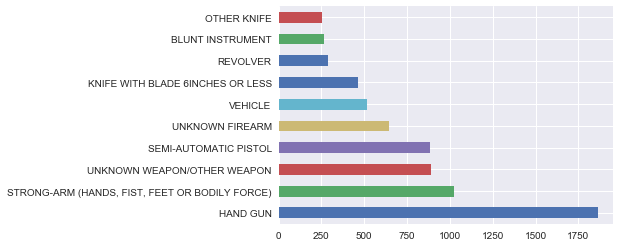

In [174]:
#Weapons most frequently used for assaults in the 77th area
area_weapons = crime_df[(crime_df['crm_cd']=='230') & (crime_df['area_id'] == '12')]
area_weapons.groupby('weapon_desc').crm_cd.count().sort_values(ascending=False).head(10)
area_weapons['weapon_desc'].value_counts()[:10].plot(kind='barh')

From the graph above we can see that the number of assaults with the use of hand guns far far surpasses all other types of assaults. Focusing on getting guns off the streets targeted at this area may help lower the number of assaults with the use of a firearm.

## When Crimes Occur

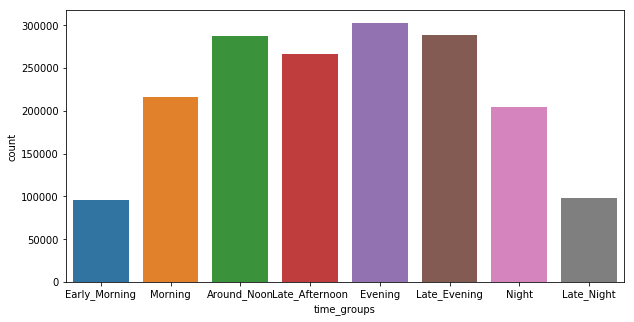

In [14]:
#Put the time crimes occur into buckets
crime_df['time'] = pd.to_numeric(crime_df['time_occ'])
def label_time(row):
    if 500 <= row < 800:
        return 'Early_Morning'
    elif 800 <= row < 1100:
        return 'Morning'
    elif 1100 <= row < 1400:
        return 'Around_Noon'
    elif 1400 <= row < 1700:
        return 'Late_Afternoon'
    elif 1700 <= row < 2000:
        return 'Evening'
    elif 2000 <= row < 2300:
        return 'Late_Evening'
    elif 2300 <= row <= 2400 or 0 <= row < 200:
        return 'Night'
    elif 200 <= row < 500:
        return 'Late_Night'
    else:
        return 'Other'

#Create new column based on function above
crime_df['time_groups'] = crime_df['time'].apply(label_time)
plt.figure(figsize=(10,5))
axis = sns.countplot(x = 'time_groups', data = crime_df, order = ['Early_Morning', 'Morning', 'Around_Noon', 'Late_Afternoon', 'Evening', 'Late_Evening', 'Night', 'Late_Night'])

In [15]:
#Get day of the week
def day_convert(date):
    return date.strftime("%A")

#Create column that contains the day of each crime
crime_df['day'] = crime_df['date'].apply(day_convert)

In [177]:
#Create larger bins to see if more crimes are occuring at a certain time of day for specific days
def label_time(row):
    if 400 <= row < 1200:
        return 'Morning'
    elif 1200 <= row < 2000:
        return 'Afternoon'
    elif 2000 <= row < 2400 or 0<=row < 400:
        return 'Night'
    
#Create a new column based on formula above
crime_df['time_groups_2'] = crime_df['time'].apply(label_time)

Text(0,0.5,'Crime Count')

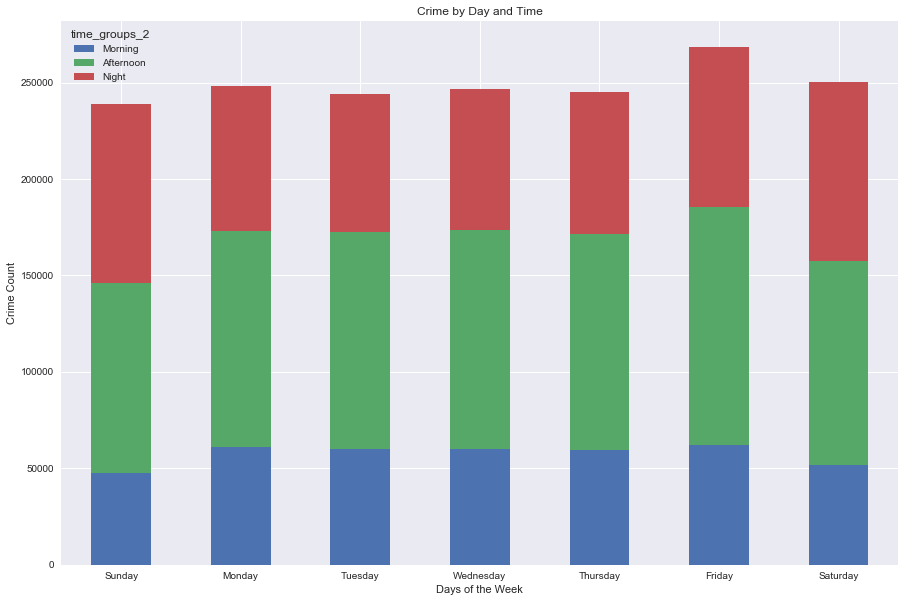

In [179]:
counts = crime_df.groupby(['day', 'time_groups_2'])['crm_cd'].count().unstack('time_groups_2').fillna(0)
m = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
counts = counts.reindex(m)
ax = counts[['Morning', 'Afternoon', 'Night']].plot(kind='bar', stacked = True, figsize=(15,10), title = 'Crime by Day and Time', rot=0)
ax.set_xlabel("Days of the Week")
ax.set_ylabel("Crime Count")

It appears that crimes are evenly spread between days with a small spike on Fridays. Fridays appear to have more crimes occuring in the afternoon. The below test exams if the increase in crime on Fridays is significant.

In [180]:
#Proportion test to see if more crimes occur on Fridays
Friday_count = crime_df[crime_df['day']=='Friday']['crm_cd'].count()
z_score, p_value = sm.stats.proportions_ztest([Friday_count, (total_count/7)], [total_count, total_count])
print(z_score, p_value)

29.713931830296595 5.0738446321286435e-194


From the test above we can see that Friday has a statistically significant increase in crimes over other days. It appears the difference is in the afternoon. Below I will examine what crimes have the largest spikes on Friday afternoon.

In [181]:
#The most common crimes occuring on Friday afternoons
Friday_Afternoon = crime_df[(crime_df['day']=='Friday') & (crime_df['time_groups_2'] == 'Afternoon')]
Friday_Afternoon.groupby('crm_cd_desc').crm_cd.count().sort_values(ascending=False).head(10)

crm_cd_desc
THEFT PLAIN - PETTY ($950 & UNDER)                              10798
BATTERY - SIMPLE ASSAULT                                        10516
BURGLARY                                                         9843
THEFT OF IDENTITY                                                9710
VEHICLE - STOLEN                                                 8309
BURGLARY FROM VEHICLE                                            8080
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114     5749
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036     5576
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)                  5167
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                         5004
Name: crm_cd, dtype: int64

Comparing the most common crimes on Friday afternoons to the most common crimes in general it apperas that different types of theft are more common on Friday afternoons. This could possibly be because individuals have debts that are due at the end of the workweek and out of desperation turn to crime.

## Victim Demographics

In [182]:
#Convert age to numerics and calculate the mean and median
crime_df['age'] = pd.to_numeric(crime_df['vict_age'])
age_mean = crime_df['age'].mean()
age_median = crime_df['age'].median()
print(age_mean)
print(age_median)

35.98372859938091
34.0


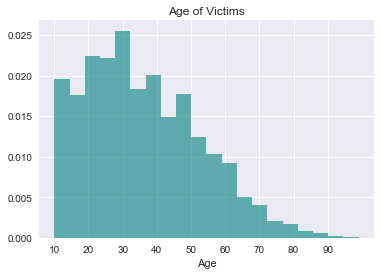

In [183]:
#Examine the distribution of age for victims
plt.xlabel('Age')
plt.title('Age of Victims')
plt.xticks(range(0, 100, 10))
plt.hist(crime_df['age'].dropna(), bins=20, density = True, stacked = True, color = 'teal', alpha = .6)
plt.show()

From this histogram we can see that the portion of the population that are the most victimized are those in their late 20s and early 30s and the risk of victimization appears to drop as individuals get older. 

In [184]:
#Calculate the amount of crimes by victim descent and victim sex
counts = crime_df.groupby(['vict_descent', 'vict_sex'])['crm_cd'].count().sort_values(ascending=False).head(8).unstack('vict_sex').fillna(0)
print(counts)

vict_sex             F         M
vict_descent                    
B             162013.0  116523.0
H             305339.0  296724.0
O              57677.0  110655.0
W             185485.0  242320.0


[Text(0,0,'Black'), Text(0,0,'Latino'), Text(0,0,'Other'), Text(0,0,'White')]

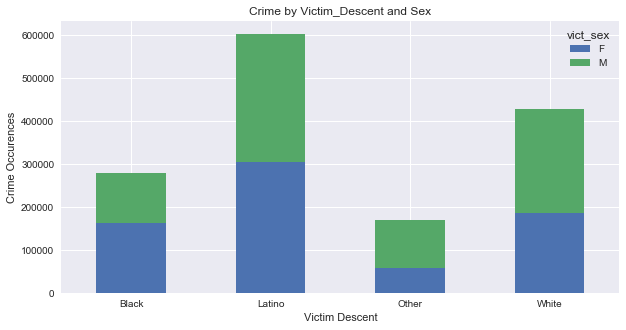

In [185]:
ax = counts[['F', 'M']].plot(kind='bar', stacked = True,figsize=(10,5), title = 'Crime by Victim_Descent and Sex', rot=0)
ax.set_xlabel('Victim Descent')
ax.set_ylabel('Crime Occurences')
ax.set_xticklabels( ('Black', 'Latino','Other', 'White') )

Victims are more likely to be hispanic, white, or black. 
Among black victims females outnumber males. This could possibly be because black victims are less likely to report a crime. This leads me to believe that the number of crimes against the black population is greater than what the data shows.
Among white victims it appears that white males are more likely to be victim of crimes than males.

In [186]:
#Crimes most expiereince by homeless individuals. 1218 refers to an mocode that indicates a homeless victim
crime_df[crime_df['mocodes'].str.contains('1218', na=False)].groupby('crm_cd_desc').crm_cd.count().sort_values(ascending=False).head()

crm_cd_desc
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT    2829
BATTERY - SIMPLE ASSAULT                          2196
ROBBERY                                           1362
THEFT PLAIN - PETTY ($950 & UNDER)                1085
INTIMATE PARTNER - SIMPLE ASSAULT                  994
Name: crm_cd, dtype: int64

Three of the five most common crimes experienced by homeless indiviuals is assault suggesting  that a larger proportion of crimes against homeless individuals are assaults

Preproccess Data for predicitve modeling

In [54]:
#Encode Dependent Variable zipcode as numbers and store in dataframe
number = LabelEncoder()
crime_df['target'] = number.fit_transform(crime_df['zipcode'].astype('str'))
label = crime_df['target']

In [17]:
#Group less common crime types
not_top = crime_df.groupby('crm_cd').crm_cd.count().sort_values(ascending=False).index[10:]
dfnew  = crime_df.replace(not_top, 'Other')

In [50]:
#Create features dataframe which includes dummy variables for categorical variables
features = pd.get_dummies(crime_df.area_name, prefix = 'area').iloc[:, 1:]
days_dm = pd.get_dummies(crime_df.day, prefix = 'day').iloc[:, 1:]
hour_dm = pd.get_dummies(crime_df.time_groups, prefix = 'time').iloc[:, 1:]
crm_dm = pd.get_dummies(crime_df.crm_cd, prefix = 'crm_cd').iloc[:, 1:]
features = pd.concat([features, hour_dm, days_dm, crm_dm], axis = 1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25)

#Create classifier
clf = RandomForestClassifier(n_estimators = 10)

#Train the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [57]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.29492143486366335


Test for Multicollinearity 

In [26]:
mc = pd.concat([features, label], axis=1)

In [27]:
#Create a function to calculate VIF for each feature
def vif_cal(input_data, dependent_col):
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        vif=round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)

In [29]:
vif_cal(input_data=mc, dependent_col="target")

area_Central  VIF =  1.56
area_Devonshire  VIF =  1.61
area_Foothill  VIF =  1.5
area_Harbor  VIF =  1.57
area_Hollenbeck  VIF =  1.47
area_Hollywood  VIF =  1.6
area_Mission  VIF =  1.64
area_N Hollywood  VIF =  1.7
area_Newton  VIF =  1.6
area_Northeast  VIF =  1.62
area_Olympic  VIF =  1.57
area_Pacific  VIF =  1.68
area_Rampart  VIF =  1.54
area_Southeast  VIF =  1.66
area_Southwest  VIF =  1.81
area_Topanga  VIF =  1.61
area_Van Nuys  VIF =  1.62
area_West LA  VIF =  1.55
area_West Valley  VIF =  1.56
area_Wilshire  VIF =  1.53
hour_1  VIF =  1.66
hour_2  VIF =  1.56
hour_3  VIF =  1.42
hour_4  VIF =  1.32
hour_5  VIF =  1.29
hour_6  VIF =  1.4
hour_7  VIF =  1.59
hour_8  VIF =  1.96
hour_9  VIF =  1.85
hour_10  VIF =  1.96
hour_11  VIF =  1.91
hour_12  VIF =  2.74
hour_13  VIF =  1.98
hour_14  VIF =  2.08
hour_15  VIF =  2.17
hour_16  VIF =  2.15
hour_17  VIF =  2.24
hour_18  VIF =  2.33
hour_19  VIF =  2.27
hour_20  VIF =  2.29
hour_21  VIF =  2.22
hour_22  VIF =  2.18
hour_23  

With no VIF with a score lower than five it appears that no variables are suffering from mulitcollinarity. 

In [63]:
features2 = pd.get_dummies(crime_df.area_name, prefix = 'area').iloc[:, 1:]
days_dm = pd.get_dummies(crime_df.day, prefix = 'day').iloc[:, 1:]
time_dm = pd.get_dummies(crime_df.time_groups, prefix = 'time_groups').iloc[:, 1:]
crm_dm = pd.get_dummies(dfnew.crm_cd, prefix = 'crm_cd').iloc[:, 1:]
features2 = pd.concat([features2, time_dm, days_dm, crm_dm], axis = 1)

In [64]:
#Split dataset into train and test sets, create RandomForestClassifier, and train model
X_train, X_test, y_train, y_test = train_test_split(features2, label, test_size=0.25)

#Create classifier
clf = RandomForestClassifier(n_estimators = 10)

#Train the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [65]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.29866133111170295


In [36]:
df_77 = crime_df[crime_df['area_id']=='12']

In [47]:
#Create features dataframe which includes dummy variables for categorical variables
features3 = pd.get_dummies(df_77.day, prefix = 'day').iloc[:, 1:]
hour_dm = pd.get_dummies(df_77.time_groups, prefix = 'hour').iloc[:, 1:]
crm_dm = pd.get_dummies(df_77.crm_cd, prefix = 'crm_cd').iloc[:, 1:]
features3 = pd.concat([features3, hour_dm, crm_dm], axis = 1)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25)

#Create classifier
clf = RandomForestClassifier(n_estimators = 10)

#Train the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [49]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3062018036857927
